# Preparing the data and query store

In [1]:
# import rdf_data_citation
import rdf_data_citation.rdf_star as rdf_star
from rdf_data_citation.rdf_star import TripleStoreEngine
from rdf_data_citation.citation_utils import QueryUtils, RDFDataSetUtils, MetaData, generate_citation_snippet, _pprint_query
import rdf_data_citation.query_store as qs
from rdf_data_citation._helper import citation_timestamp_format 
from rdf_data_citation.prefixes import attach_prefixes
# import queries_for_testing as q

import rdflib.plugins.sparql.algebra as algebra
from datetime import datetime, timedelta, timezone
import pandas as pd
from rdflib.term import Variable
from IPython.display import Image
import configparser
import json
import logging

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

## R1 - Data Versioning

Coming from relational databases a triple store can be imagined as a table with three fields - subject, predicate, object. if one were about to annotate a triple with a timestamp or other label the fact that no additional “column” can be used within a triple store but only additional rows would make it hard to reference a specific triple. All that could be done is to insert another triple to somehow reference the target triple. However, where would this new triple point at or what would be the subject? Figure 1 illustrates this problem


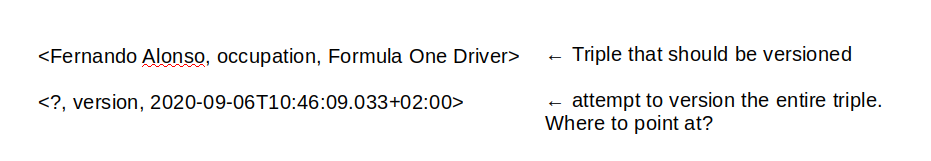

In [2]:
Image(filename='figures/figure 1.png')

One can easily see the problem that the placeholder ? can only take one piece of information (subject or object) of the target triple which does not suffice to reference the triple as a whole. However, if one were able to nest a whole triple within the subject of another it would endow us with the right tool to address data versioning within triple stores. In fact, RDF* and SPARQL* as extensions of RDF and SPARQL respectively are capable of doing exactly this. Figure 2 illustrates the solution for the example brought in figure 1 in actual RDF* syntax.


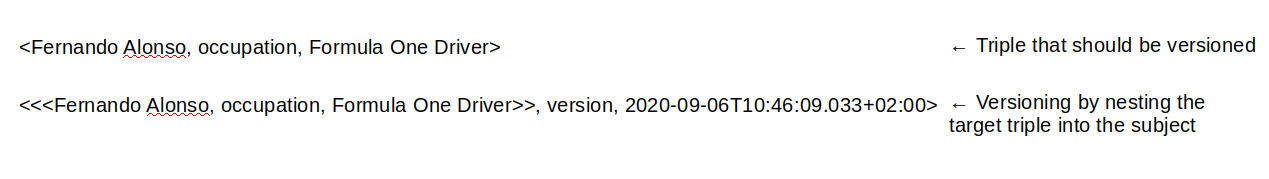

In [3]:
Image(filename='figures/figure 2.png')

This capability of nesting triples is only part of the solution. However, now we can use existing methods that also can be used within relational databases. One way is to use a start and an end date for each triple. As an initial operation all triples should be annotated with the current timestamp as the start date and an end date that is far in the future, e.g. 9999-12-31T00:00.000. From here we have to distinguish between insert, update and delete operations. Finally, to retrieve data as it existed at a certain point in time we would use simple filter operations on the start date and end date attributes. 


### Insert

Whenever a new triple is inserted two additional triples will be inserted - one marking the start date (e.g. current timestamp) of that triple and one setting the end date to 9999-12-31T00:00.000 to mark it as valid until further notice. 


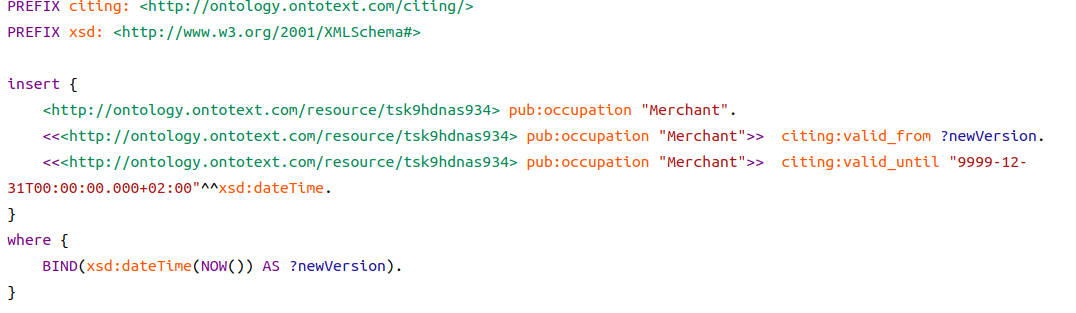

In [4]:
Image(filename='figures/figure 3.png')

### Update

The update operation is a combination of a delete operation followed by an insert. We first must make clear what is actually updated. Here it again helps to think in terms of relational databases. The subject can be seen as a table, the predicate as an attribute of that table and the object as a particular value of that attribute. As we are updating data it goes without saying that we want to perform these operations on the object (the value) of the triple. Therefore, we first perform a delete on the end date of the target triple. Subsequently, we want to give a new end date to the target triple and this could be the current timestamp as this operation is performed. So far, we have only outdated the old value. What is now left to do is to basically perform the same operation as in Insert chapter. 

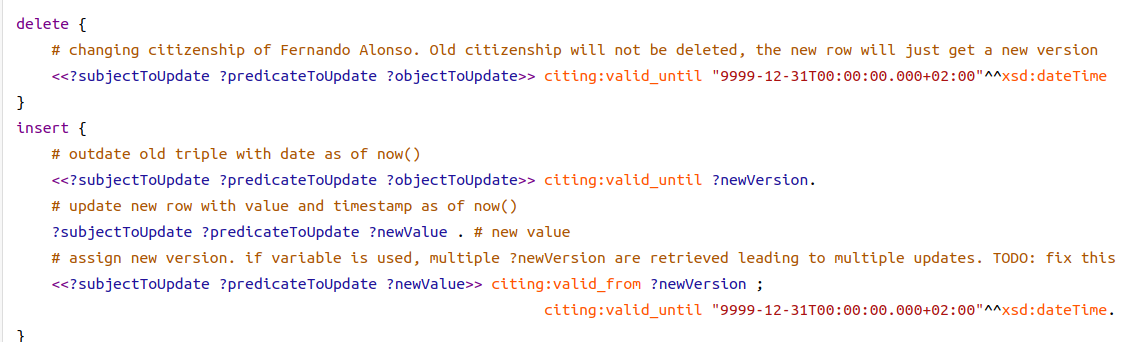

In [5]:
Image(filename='figures/figure 4.png')

### Delete

The idea for the delete operation has already been conceived in the first part of the update operation. Firstly, the target triple’s end date is deleted and secondly the target triple is provided with a new end date, e.g. as of operation date. 


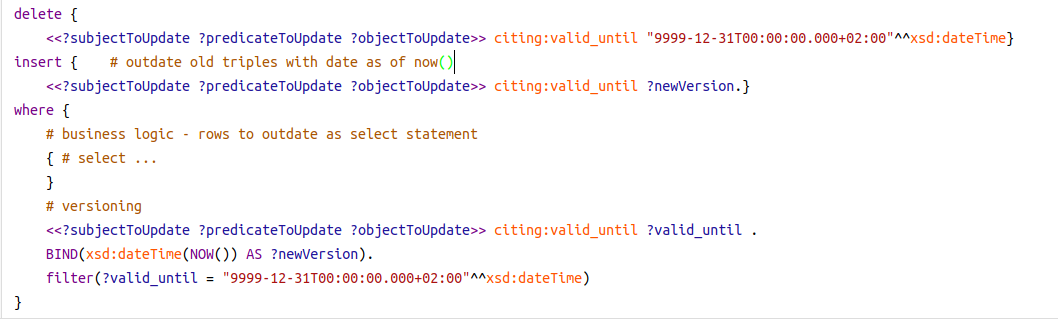

In [6]:
Image(filename='figures/figure 7.png')

### Proof of concept
Following example shall demonstrate that with the above discussed solution it is possible to retrieve earlier states of the data. 

In [7]:
# Go to GraphDB --> Repositories --> Click on the link symbol of the DataCitation repository and copy the url
# get: <url>
# post: <url>/statements
# Save to config.ini file

"""Load configuration from .ini file."""
config = configparser.ConfigParser()
config.read('../../config.ini')

# set up endpoints and prepare RDF store for demonstration
rdf_engine = TripleStoreEngine(config.get('RDFSTORE', 'get'), config.get('RDFSTORE', 'post')) #POST

INFO:root:Connection to RDF query and update endpoints http://192.168.0.241:7200/repositories/DataCitation and http://192.168.0.241:7200/repositories/DataCitation/statements established


In [8]:
vieTZObject = timezone(timedelta(hours=2))
# Initial timestamp for valid_from date only needed in Q_PERF mode (see config.ini)
versioning_mode = config.get('VERSIONING', 'versioning_mode')
print(versioning_mode)
if versioning_mode == 'Q_PERF':
    initial_timestamp = datetime(2020, 9, 1, 12, 11, 21, 941000, vieTZObject)
    vers_mode = rdf_star.VersioningMode.Q_PERF
    rdf_engine.version_all_rows(initial_timestamp, vers_mode)
elif versioning_mode == 'SAVE_MEM':
    initial_timestamp = datetime.now(vieTZObject)
    vers_mode = rdf_star.VersioningMode.SAVE_MEM
    rdf_engine.version_all_rows(versioning_mode=vers_mode)
else:
    raise Exception("Versioning mode must either be Q_PERF or SAVE_MEM")


SAVE_MEM


INFO:root:All rows have been annotated with an artificial end date.


During the timestamping two additional prefixes will be added, namely  
PREFIX citing: <http://ontology.ontotext.com/citing/> and PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>. Below is an example query we will use throughout this notebook. It also has a subquery with a different variable set in the select clause than the outer one. This way, we will test whether the the right variable set will be selected for the result set.

In [9]:
# Prepare test query and timestamps
original_query = """
PREFIX pub: <http://ontology.ontotext.com/taxonomy/>
PREFIX publishing: <http://ontology.ontotext.com/publishing#>

select ?personLabel ?party_label ?document ?mention {
    ?mention publishing:hasInstance ?person .
    ?document publishing:containsMention ?mention . 
    ?person pub:memberOfPoliticalParty ?party .
    ?person pub:preferredLabel ?personLabel .
    ?party pub:hasValue ?value .
    ?value pub:preferredLabel ?party_label .
    bind(?value as ?value_bind)
    bind(?mention as ?mention_bind)

    filter(?personLabel = "Barack Obama"@en)
} order by ?mention
"""
rdf_engine.get_data(original_query) # dataframe

INFO:root:Get data ...
INFO:root:Timestamped query with timestamp 2021-06-19T16:43:36.882847+01:00 being executed: 
 
PREFIX citing: <https://github.com/GreenfishK/DataCitation/citing/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?personLabel ?party_label ?document ?mention{FILTER(?personLabel = "Barack Obama"@en) ?mention <http://ontology.ontotext.com/publishing#hasInstance> ?person.?person <http://ontology.ontotext.com/taxonomy/memberOfPoliticalParty> ?party.?party <http://ontology.ontotext.com/taxonomy/hasValue> ?value.?person <http://ontology.ontotext.com/taxonomy/preferredLabel> ?personLabel.?document <http://ontology.ontotext.com/publishing#containsMention> ?mention.?value <http://ontology.ontotext.com/taxonomy/preferredLabel> ?party_label.<<?mention <http://ontology.ontotext.com/publishing#hasInstance> ?person>> citing:valid_until ?triple_statement_0_valid_until.
filter(?TimeOfCitingBGP_0 < ?triple_statement_0_valid_until)
optional {<<?mention <http://ontology.ontote

,personLabel,party_label,document,mention
0,Barack Obama@en,Democratic Party@en,http://www.reuters.com/article/2014/10/10/us-health-ebola-usa-idUSKCN0HY2A520141010,http://data.ontotext.com/publishing#Mention-705a80ff154a6c9cce8ad6fa1aca37249c12bada619cdaffa5afd55aee07953f
1,Barack Obama@en,Democratic Party@en,http://www.reuters.com/article/2014/10/10/us-usa-california-mountains-idUSKCN0HZ0U720141010,http://data.ontotext.com/publishing#Mention-73bb312bbde27a704a4e4cb4c25942b37c771e6f93cb7d9f163650728a67f75c
2,Barack Obama@en,Democratic Party@en,http://www.reuters.com/article/2014/10/10/us-usa-california-mountains-idUSKCN0HZ0U720141010,http://data.ontotext.com/publishing#Mention-96cd9530c126974107c405f240907337db267d369e851e904b21ad75955473af
3,Barack Obama@en,Democratic Party@en,http://www.reuters.com/article/2014/10/10/us-usa-california-mountains-idUSKCN0HZ0U720141010,http://data.ontotext.com/publishing#Mention-a7a06bb06c91289740a7888691757b1b2ec39a7cf3908aa885dc9cf070852b06
4,Barack Obama@en,Democratic Party@en,http://www.reuters.com/article/2014/10/10/us-usa-california-mountains-idUSKCN0HZ0U720141010,http://data.ontotext.com/publishing#Mention-aea1154aa5adc65e96bf204e790b762f01cf1f87380358222f33ba182278ba82
5,Barack Obama@en,Democratic Party@en,http://www.reuters.com/article/2014/10/10/us-usa-california-mountains-idUSKCN0HZ0U720141010,http://data.ontotext.com/publishing#Mention-d29176c43a5c6f95bb0820be4e215f9f6c6baca52e85a09da5a50dc46a348c2d


Let's make Obama a Rebublican now...

In [10]:
prefixes = {'pub': 'http://ontology.ontotext.com/taxonomy/'}
triples_to_update = {('<http://ontology.ontotext.com/resource/tsk4wye1ftog>',
                      'pub:memberOfPoliticalParty', 
                    '<http://ontology.ontotext.com/resource/Q76SBFD36E46-359B-445A-8EC2-A3BDDFF5E900>'):
                    '<http://ontology.ontotext.com/resource/Q201795S476DFED9-C64A-4E56-B4C3-CFB368801FBF>'}
rdf_engine.update(triples_to_update, prefixes)

INFO:root:<SPARQLWrapper.Wrapper.QueryResult object at 0x00007F2470714B50>
{"requestedFormat" : 'xml',
"response (a file-like object, as return by the urllib2.urlopen library call)" : {
	"url" : "http://192.168.0.241:7200/repositories/DataCitation/statements",
	"code" : "204",
	"headers" : Vary: Accept-Encoding
Cache-Control: no-store
Content-Language: de-AT
Date: Sat, 19 Jun 2021 15:43:46 GMT
Connection: close
Server: GraphDB-Free/9.5.0 RDF4J/3.4.4

}} rows updated


In [11]:
timestamp1 = datetime.now(vieTZObject)
rdf_engine.get_data(original_query, timestamp1)

INFO:root:Get data ...
INFO:root:Timestamped query with timestamp 2021-06-19T17:43:46.999760+02:00 being executed: 
 
PREFIX citing: <https://github.com/GreenfishK/DataCitation/citing/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?personLabel ?party_label ?document ?mention{FILTER(?personLabel = "Barack Obama"@en) ?mention <http://ontology.ontotext.com/publishing#hasInstance> ?person.?person <http://ontology.ontotext.com/taxonomy/memberOfPoliticalParty> ?party.?party <http://ontology.ontotext.com/taxonomy/hasValue> ?value.?person <http://ontology.ontotext.com/taxonomy/preferredLabel> ?personLabel.?document <http://ontology.ontotext.com/publishing#containsMention> ?mention.?value <http://ontology.ontotext.com/taxonomy/preferredLabel> ?party_label.<<?mention <http://ontology.ontotext.com/publishing#hasInstance> ?person>> citing:valid_until ?triple_statement_0_valid_until.
filter(?TimeOfCitingBGP_0 < ?triple_statement_0_valid_until)
optional {<<?mention <http://ontology.ontote

,personLabel,party_label,document,mention
0,Barack Obama@en,Republican Party@en,http://www.reuters.com/article/2014/10/10/us-health-ebola-usa-idUSKCN0HY2A520141010,http://data.ontotext.com/publishing#Mention-705a80ff154a6c9cce8ad6fa1aca37249c12bada619cdaffa5afd55aee07953f
1,Barack Obama@en,Republican Party@en,http://www.reuters.com/article/2014/10/10/us-usa-california-mountains-idUSKCN0HZ0U720141010,http://data.ontotext.com/publishing#Mention-73bb312bbde27a704a4e4cb4c25942b37c771e6f93cb7d9f163650728a67f75c
2,Barack Obama@en,Republican Party@en,http://www.reuters.com/article/2014/10/10/us-usa-california-mountains-idUSKCN0HZ0U720141010,http://data.ontotext.com/publishing#Mention-96cd9530c126974107c405f240907337db267d369e851e904b21ad75955473af
3,Barack Obama@en,Republican Party@en,http://www.reuters.com/article/2014/10/10/us-usa-california-mountains-idUSKCN0HZ0U720141010,http://data.ontotext.com/publishing#Mention-a7a06bb06c91289740a7888691757b1b2ec39a7cf3908aa885dc9cf070852b06
4,Barack Obama@en,Republican Party@en,http://www.reuters.com/article/2014/10/10/us-usa-california-mountains-idUSKCN0HZ0U720141010,http://data.ontotext.com/publishing#Mention-aea1154aa5adc65e96bf204e790b762f01cf1f87380358222f33ba182278ba82
5,Barack Obama@en,Republican Party@en,http://www.reuters.com/article/2014/10/10/us-usa-california-mountains-idUSKCN0HZ0U720141010,http://data.ontotext.com/publishing#Mention-d29176c43a5c6f95bb0820be4e215f9f6c6baca52e85a09da5a50dc46a348c2d


Let us now assume that a new mention of Obama is found within a document and gets added to the tripple store. If we take the initial timestamp again and execute the query we see that the result has not changed, which is what we expected. However, the query with the most recent timestamp (sysdate) will return the dataset where the newly added triples are visible.

In [12]:
prefixes = {'pub': 'http://ontology.ontotext.com/taxonomy/',
            'publishing': 'http://ontology.ontotext.com/publishing#'}

mention = "<http://data.ontotext.com/publishing#Mention-dbaa4de4563be5f6b927c87e09f90461c09451296f4b52b1f80dcb6e941a5acd>"
hasInstance = "publishing:hasInstance"
person = "<http://ontology.ontotext.com/resource/tsk4wye1ftog>"

rdf_engine.insert_triples([mention, hasInstance, person], prefixes)

document = "<http://www.reuters.com/article/2014/10/10/us-usa-california-mountains-idUSKCN0HZ0U720141010>"
containsMention = "publishing:containsMention"
mention = "<http://data.ontotext.com/publishing#Mention-dbaa4de4563be5f6b927c87e09f90461c09451296f4b52b1f80dcb6e941a5acd>"

rdf_engine.insert_triples([document, containsMention, mention], prefixes)

INFO:root:Triple ['<http://data.ontotext.com/publishing#Mention-dbaa4de4563be5f6b927c87e09f90461c09451296f4b52b1f80dcb6e941a5acd>', 'publishing:hasInstance', '<http://ontology.ontotext.com/resource/tsk4wye1ftog>'] successfully inserted: 
INFO:root:Triple ['<http://www.reuters.com/article/2014/10/10/us-usa-california-mountains-idUSKCN0HZ0U720141010>', 'publishing:containsMention', '<http://data.ontotext.com/publishing#Mention-dbaa4de4563be5f6b927c87e09f90461c09451296f4b52b1f80dcb6e941a5acd>'] successfully inserted: 


In [13]:
# Newly added triples
timestamp2 = datetime.now(vieTZObject)
rdf_engine.get_data(original_query, timestamp2)

INFO:root:Get data ...
INFO:root:Timestamped query with timestamp 2021-06-19T17:43:52.572912+02:00 being executed: 
 
PREFIX citing: <https://github.com/GreenfishK/DataCitation/citing/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?personLabel ?party_label ?document ?mention{FILTER(?personLabel = "Barack Obama"@en) ?mention <http://ontology.ontotext.com/publishing#hasInstance> ?person.?person <http://ontology.ontotext.com/taxonomy/memberOfPoliticalParty> ?party.?party <http://ontology.ontotext.com/taxonomy/hasValue> ?value.?person <http://ontology.ontotext.com/taxonomy/preferredLabel> ?personLabel.?document <http://ontology.ontotext.com/publishing#containsMention> ?mention.?value <http://ontology.ontotext.com/taxonomy/preferredLabel> ?party_label.<<?mention <http://ontology.ontotext.com/publishing#hasInstance> ?person>> citing:valid_until ?triple_statement_0_valid_until.
filter(?TimeOfCitingBGP_0 < ?triple_statement_0_valid_until)
optional {<<?mention <http://ontology.ontote

,personLabel,party_label,document,mention
0,Barack Obama@en,Republican Party@en,http://www.reuters.com/article/2014/10/10/us-health-ebola-usa-idUSKCN0HY2A520141010,http://data.ontotext.com/publishing#Mention-705a80ff154a6c9cce8ad6fa1aca37249c12bada619cdaffa5afd55aee07953f
1,Barack Obama@en,Republican Party@en,http://www.reuters.com/article/2014/10/10/us-usa-california-mountains-idUSKCN0HZ0U720141010,http://data.ontotext.com/publishing#Mention-73bb312bbde27a704a4e4cb4c25942b37c771e6f93cb7d9f163650728a67f75c
2,Barack Obama@en,Republican Party@en,http://www.reuters.com/article/2014/10/10/us-usa-california-mountains-idUSKCN0HZ0U720141010,http://data.ontotext.com/publishing#Mention-96cd9530c126974107c405f240907337db267d369e851e904b21ad75955473af
3,Barack Obama@en,Republican Party@en,http://www.reuters.com/article/2014/10/10/us-usa-california-mountains-idUSKCN0HZ0U720141010,http://data.ontotext.com/publishing#Mention-a7a06bb06c91289740a7888691757b1b2ec39a7cf3908aa885dc9cf070852b06
4,Barack Obama@en,Republican Party@en,http://www.reuters.com/article/2014/10/10/us-usa-california-mountains-idUSKCN0HZ0U720141010,http://data.ontotext.com/publishing#Mention-aea1154aa5adc65e96bf204e790b762f01cf1f87380358222f33ba182278ba82
5,Barack Obama@en,Republican Party@en,http://www.reuters.com/article/2014/10/10/us-usa-california-mountains-idUSKCN0HZ0U720141010,http://data.ontotext.com/publishing#Mention-d29176c43a5c6f95bb0820be4e215f9f6c6baca52e85a09da5a50dc46a348c2d
6,Barack Obama@en,Republican Party@en,http://www.reuters.com/article/2014/10/10/us-usa-california-mountains-idUSKCN0HZ0U720141010,http://data.ontotext.com/publishing#Mention-dbaa4de4563be5f6b927c87e09f90461c09451296f4b52b1f80dcb6e941a5acd


In [14]:
rdf_engine.get_data(original_query, initial_timestamp)

INFO:root:Get data ...
INFO:root:Timestamped query with timestamp 2021-06-19T17:43:13.118981+02:00 being executed: 
 
PREFIX citing: <https://github.com/GreenfishK/DataCitation/citing/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?personLabel ?party_label ?document ?mention{FILTER(?personLabel = "Barack Obama"@en) ?mention <http://ontology.ontotext.com/publishing#hasInstance> ?person.?person <http://ontology.ontotext.com/taxonomy/memberOfPoliticalParty> ?party.?party <http://ontology.ontotext.com/taxonomy/hasValue> ?value.?person <http://ontology.ontotext.com/taxonomy/preferredLabel> ?personLabel.?document <http://ontology.ontotext.com/publishing#containsMention> ?mention.?value <http://ontology.ontotext.com/taxonomy/preferredLabel> ?party_label.<<?mention <http://ontology.ontotext.com/publishing#hasInstance> ?person>> citing:valid_until ?triple_statement_0_valid_until.
filter(?TimeOfCitingBGP_0 < ?triple_statement_0_valid_until)
optional {<<?mention <http://ontology.ontote

,personLabel,party_label,document,mention
0,Barack Obama@en,Democratic Party@en,http://www.reuters.com/article/2014/10/10/us-health-ebola-usa-idUSKCN0HY2A520141010,http://data.ontotext.com/publishing#Mention-705a80ff154a6c9cce8ad6fa1aca37249c12bada619cdaffa5afd55aee07953f
1,Barack Obama@en,Democratic Party@en,http://www.reuters.com/article/2014/10/10/us-usa-california-mountains-idUSKCN0HZ0U720141010,http://data.ontotext.com/publishing#Mention-73bb312bbde27a704a4e4cb4c25942b37c771e6f93cb7d9f163650728a67f75c
2,Barack Obama@en,Democratic Party@en,http://www.reuters.com/article/2014/10/10/us-usa-california-mountains-idUSKCN0HZ0U720141010,http://data.ontotext.com/publishing#Mention-96cd9530c126974107c405f240907337db267d369e851e904b21ad75955473af
3,Barack Obama@en,Democratic Party@en,http://www.reuters.com/article/2014/10/10/us-usa-california-mountains-idUSKCN0HZ0U720141010,http://data.ontotext.com/publishing#Mention-a7a06bb06c91289740a7888691757b1b2ec39a7cf3908aa885dc9cf070852b06
4,Barack Obama@en,Democratic Party@en,http://www.reuters.com/article/2014/10/10/us-usa-california-mountains-idUSKCN0HZ0U720141010,http://data.ontotext.com/publishing#Mention-aea1154aa5adc65e96bf204e790b762f01cf1f87380358222f33ba182278ba82
5,Barack Obama@en,Democratic Party@en,http://www.reuters.com/article/2014/10/10/us-usa-california-mountains-idUSKCN0HZ0U720141010,http://data.ontotext.com/publishing#Mention-d29176c43a5c6f95bb0820be4e215f9f6c6baca52e85a09da5a50dc46a348c2d


## R2 - Timestamping 

Operations on data should be timestamped. If we look at the suggested solution for R1, we see that timestamps are already applied with every operation. Now, one could use the operation timestamp for both - versioning data and timestamping the operation itself. The proposed solution for R1 would allow retrieving each operation’s timestamp but also a specific version of the dataset (as it was at a specific point in time). The start date annotation tells us also the timestamp of the insert and update operation. If a semantically valid end date (not 9999-12-31T00:00.000) is used to mark triples as outdated it can also be seen as the timestamp of the delete operation. 
However, if one wants to distinguish between a real delete and a delete as part of an update, this approach would lead to ambiguity. Therefore, another proposed solution is to use a further annotation “operation_date” and stamp the operation itself. This solution has the following benefit: A different timestamp than the operation timestamp could be used for versioning data. Some use cases might require to version data with specific timestamps (E.g. end of the day the operation was performed)


## R3 - Query Store Facilities

The query store is a means to store queries and the associated metadata. For the query store it is not important whether the underlying database is a graph database, document-based or relational database. The query itself is just a string of characters in all cases and a simple database like SQLite in combination with Python’s object relational mapper SQL Alchemy is used to build the Query Store. Upon examination of metadata available in Query Store implementations by EODC, VMC, CCCA, EHR and VAMDC we concluded that our Query Store will contain following information.

<!DOCTYPE html>
<html>
<head>
<style>
table {
  font-family: arial, sans-serif;
  border-collapse: collapse;
  width: 100% !important; 
  font-size: 24px;
}

td, th {
  border: 1px solid #bbbbbb;
  text-align: left;
  padding: 8px;
  font-size: 24px;
}

tr:nth-child(even) {
  background-color: #ffffff;
}
</style>
</head>
<body>

<table style="width: 100%; font-family: arial, sans-serif; border-collapse: collapse; font-size: 18px;">
  <tr>
    <th>Concept</th>
    <th>Attribute</th>
  </tr>
  <tr>
    <td rowspan=6 style="border: 1px solid #bbbbbb; font-size: 30px;">Query</td>
    <td>Original statement</td>
  </tr>
  <tr>
    <td>PID (See R8)</td>
  </tr>
  <tr >
    <td>Last citation PID</td>
  </tr>
  <tr>
    <td>Checksum (See R4)</td>
  </tr>
  <tr >
    <td>SPARQL prefixes</td>
  </tr>
  <tr>
    <td>Normalized query tree (See R4)</td>
  </tr>
  <tr>
    <td rowspan=3 style="border: 1px solid #bbbbbb; font-size: 30px;">Dataset</td>
    <td>Checksum (See R6)</td>
  </tr>
  <tr>
    <td>Description</td>
  </tr>
  <tr>
    <td>Sort order</td>
  </tr>
  <tr>
    <td rowspan=3 style="border: 1px solid #bbbbbb; background: white; font-size: 30px;">Citation</td>
    <td>Provenance information</td>
  </tr>
  <tr>
    <td>Citation Timestamp (See R7)</td>
  </tr>
  <tr >
    <td>Snippet</td>
  </tr>
</table>

</body>
</html>


# Persistently Identify Specific Data Sets

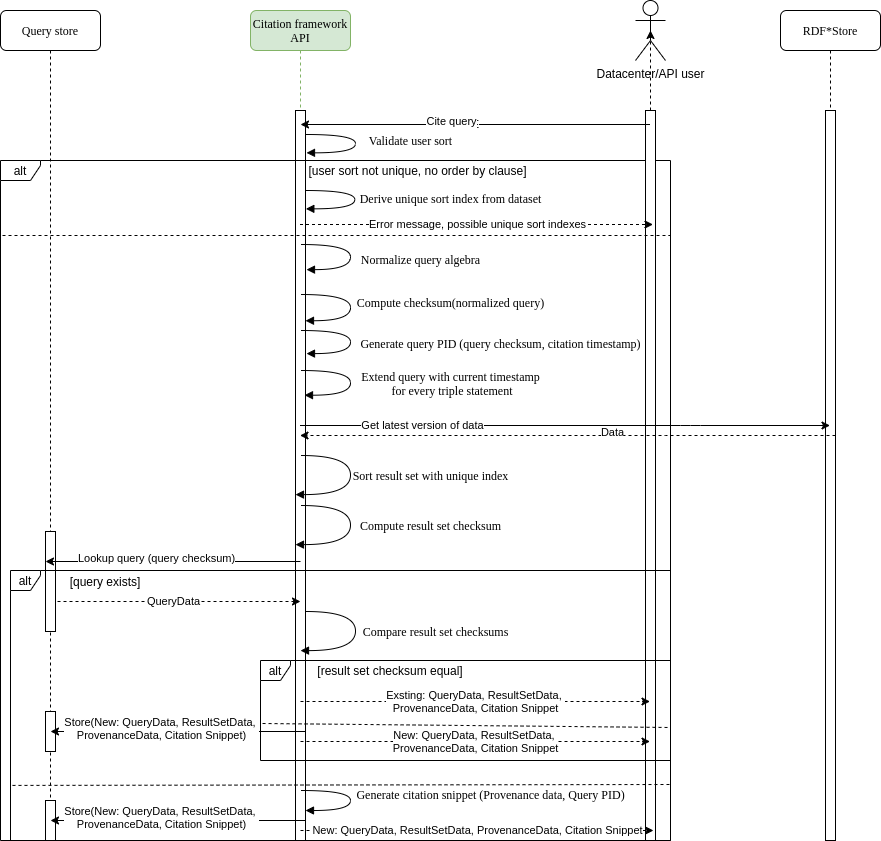

In [15]:
Image(filename='figures/figure 5.png')

A user retrieves data via an user interface by either executing a query or using graphical features to build the data set (which, in fact, executes a query in the background). At any point the user can request the citation text by means of graphical features (e.g. button) or terminal commands. Following example shall demonstrate the citation process as illustrated in figure 5.

## Case 1: Query is new

In [16]:
queryUtils = QueryUtils(original_query, timestamp1)

print(queryUtils.sparql_prefixes)
print(queryUtils.query)

PREFIX pub: <http://ontology.ontotext.com/taxonomy/>
PREFIX publishing: <http://ontology.ontotext.com/publishing#>



select ?personLabel ?party_label ?document ?mention {
    ?mention publishing:hasInstance ?person .
    ?document publishing:containsMention ?mention . 
    ?person pub:memberOfPoliticalParty ?party .
    ?person pub:preferredLabel ?personLabel .
    ?party pub:hasValue ?value .
    ?value pub:preferredLabel ?party_label .
    bind(?value as ?value_bind)
    bind(?mention as ?mention_bind)

    filter(?personLabel = "Barack Obama"@en)
} order by ?mention



### R4a - Query uniqueness: Normalize query algebra

| Number | Statement description | Normalization measure   |
|:------|:------|:------|
|1 | WHERE clause is optional | A where clause will always be inserted |
|2 | "rdf:type" predicate can be replaced by "a" | rdf:type will always be replaced by "a" |
|3 | if all variables are selected one does not need to write a variable in the form ?s but can just use an asterisk | Variables will always be explicitely mentioned and ordered alphabetically. However, this does not mean that a query with explicitly stated variables will be equivalent to a query that uses the asterisk as a shortcut to select all variables. This is due to the importance of the variables' order in the select clause. |
|4 | If the same subject is used multiple times in subsequent triple statements (separated by a dot) it can be left out in all the subsequent triple statements where the subject occurs. Instead of the subject variable name a semicolon is written in subsequent triple statements where the same subject as in the first statement should be used. | Triples will never be simplified and simplified triples will be made explicit |
|5 |   The order of triple statements does not affect the outcome | Triple statements will be ordered alphabetically by subject, predicate, object |
|6 | Aliases via BIND keyword just rename variables but the query result stays the same.  | This is tackled using regex and removing the aliases from the query and the whole bind statement. This is a valid approach because variable names are renamed anyways during step # 7 |
|7 | Variable names in general can differ between two queries without changing the outcome.  | Variables will be replaced by letters from the alphabet. For each variable a letter from the alphabet will be assigned starting with 'a' and in chronological order. Two letters will be used and chronological combinations will be assigned should there be more than 26 variables.  |
|8 | Finding variables that are not bound can be written in two ways: 1. with optional keyword adding the optional triplet combined with filter condition: "OPTIONAL { ?x dc:date ?date } filter (!bound(?date))" 2. with "filter not exists {triple}" | Regex will be used to convert "filter not exists {triple}" into the "filter + !bound" statement. |
|9 | Inverting the order of the triple statement (object predicate subject instead of subject predicate object) using "^" yields the same result as if actually exchanging the subject and object within the triple statement. | Inverted triples will be back-inverted and "^" will thereby be removed |
|10 | Sequence paths can reduce the number of triple statements in the query and are commonly used. | Sequence paths will be made explicit in form triple statements |
|11 | Prefixes can be interchanged in the prefix section before the query and subsequently in the query without changing the outcome. | All prefixes will be substituted with their underlying URIs |

Now we apply the normalization step on our example query which covers RDF statements from the table above.

In [17]:
normal_query_tree = queryUtils.normalize_query_tree(original_query)
print("Normalized Query Algebra__________________________________________________________________________________________")
algebra.pprintAlgebra(normal_query_tree)
print("Normalized Query__________________________________________________________________________________________________")
_pprint_query(queryUtils.normal_query)

Normalized Query Algebra__________________________________________________________________________________________
SelectQuery(
    p = Project(
        p = OrderBy(
            p = Filter(
                expr = RelationalExpression(
                    expr = a
                    op = =
                    other = Barack Obama
                    _vars = set()
                    )
                p = BGP(
                    triples = [(rdflib.term.Variable('d'), rdflib.term.URIRef('http://ontology.ontotext.com/publishing#hasInstance'), rdflib.term.Variable('e')), (rdflib.term.Variable('e'), rdflib.term.URIRef('http://ontology.ontotext.com/taxonomy/memberOfPoliticalParty'), rdflib.term.Variable('f')), (rdflib.term.Variable('f'), rdflib.term.URIRef('http://ontology.ontotext.com/taxonomy/hasValue'), rdflib.term.Variable('g')), (rdflib.term.Variable('e'), rdflib.term.URIRef('http://ontology.ontotext.com/taxonomy/preferredLabel'), rdflib.term.Variable('a')), (rdflib.term.Variable('c'),

#### Proof of concept

To proof that normalized query objects of semantically identical queries yield the same checksums a bunch of semantically identical queries with respect to aforementioned semantics are prepared. Then the queries are normalized by normalizing their individual "algebra trees" and their checksums are computed. We can see that all checksums are equal, which is the expected result.

In [18]:
prefixes = {'pub': 'http://ontology.ontotext.com/taxonomy/',
            'publishing': 'http://ontology.ontotext.com/publishing#'}

#1: WHERE clause is optional
query_1 = """
select ?document ?mention ?personLabel ?value {
    ?mention publishing:hasInstance ?person .
    ?document publishing:containsMention ?mention . 
    ?person pub:memberOfPoliticalParty ?party .
    ?person pub:preferredLabel ?personLabel .
    ?party pub:hasValue ?value .
    ?value pub:preferredLabel ?preflab .
    filter(?preflab = "Democratic Party"@en)
    filter(?personLabel = "Judy Chu"@en)
} order by ?document ?mention ?person
"""

#5: The order of triple statements does not affect the outcome
query_5 = """
select ?document ?mention ?personLabel ?value {
    ?person pub:preferredLabel ?personLabel .
    ?mention publishing:hasInstance ?person .
    ?document publishing:containsMention ?mention . 
    ?value pub:preferredLabel ?preflab .
    ?party pub:hasValue ?value .
    ?person pub:memberOfPoliticalParty ?party .
    filter(?preflab = "Democratic Party"@en)
    filter(?personLabel = "Judy Chu"@en)
} order by ?document ?mention ?person
"""

# Aliases via BIND keyword just rename variables but the query result stays the same.
query_6_1 = """
select ?document ?mention ?personLabel (?value as ?party_label) where {
    ?document publishing:containsMention ?mention . 
    ?person pub:memberOfPoliticalParty / pub:hasValue ?value .
    ?person pub:preferredLabel ?personLabel .
    ?mention publishing:hasInstance ?person .
    ?value pub:preferredLabel ?preflab .
    filter(?preflab = "Democratic Party"@en)
    filter(?personLabel = "Judy Chu"@en)
} order by ?document ?mention ?person
"""

query_6_2 = """
select ?document ?mention ?personLabel ?party_label where {
    ?document publishing:containsMention ?mention . 
    ?person pub:memberOfPoliticalParty / pub:hasValue ?value .
    ?person pub:preferredLabel ?personLabel .
    ?mention publishing:hasInstance ?person .
    ?value pub:preferredLabel ?preflab .
    filter(?preflab = "Democratic Party"@en)
    filter(?personLabel = "Judy Chu"@en)
    bind(?value as ?party_label)
} order by ?document ?mention ?person
"""

#7: Variable names in general can differ between two queries without changing the outcome
query_7 = """
select ?x ?mention ?personLabel ?value where {
    ?x publishing:containsMention ?mention . 
    ?person pub:memberOfPoliticalParty ?party .
    ?person pub:preferredLabel ?personLabel .
    ?mention publishing:hasInstance ?person .
    ?party pub:hasValue ?value .
    ?value pub:preferredLabel ?preflab .
    filter(?preflab = "Democratic Party"@en)
    filter(?personLabel = "Judy Chu"@en)
} order by ?x ?mention ?person
"""

#10: Sequence paths can reduce the number of triple statements in the query and are commonly used.
# Sequence paths can be resolved to explicit triple statements without changing the query's semnatic.
query_10 = """
select ?document ?mention ?personLabel ?value where {
    ?document publishing:containsMention ?mention . 
    ?person pub:memberOfPoliticalParty / pub:hasValue ?value .
    ?person pub:preferredLabel ?personLabel .
    ?mention publishing:hasInstance ?person .
    ?value pub:preferredLabel ?preflab .
    filter(?preflab = "Democratic Party"@en)
    filter(?personLabel = "Judy Chu"@en)
} order by ?document ?mention ?person
"""


queries = {"query1": query_1, 
           "query5": query_5,
           "query6_1": query_6_1, 
           "query6_2": query_6_2, 
           "query7": query_7, 
           "query10": query_10}

In [19]:
def query_checksum_workflow(query_without_prefixes: str, query_name: str, prefixes: dict, timestamp: datetime):
    query_string = attach_prefixes(query_without_prefixes, prefixes)
    q_utils = QueryUtils(query_string, timestamp)
    # normalized_query_tree: Can also be used as an input to checksum computation.
    # There are pros and cons for query and query algebra.
    # normalized_query_tree = str(q_utils.normalize_query_tree(query_string).algebra) 
    query_checksum = q_utils.compute_checksum(q_utils.normal_query) 
    print("{0}: \t \t checksum {1} ".format(query_name, query_checksum))

for query_name, query_string in queries.items():
    # Warning comes from parser.parseQuery (external lib) in _query_algebra if Literal has white space in triple statement
    query_checksum_workflow(query_string, query_name, prefixes, timestamp1)

query1: 	 	 checksum b89fce38170015eebc5920083b248bdfebb900c626ff598235c4a227d7a1fe48 
query5: 	 	 checksum b89fce38170015eebc5920083b248bdfebb900c626ff598235c4a227d7a1fe48 
query6_1: 	 	 checksum b89fce38170015eebc5920083b248bdfebb900c626ff598235c4a227d7a1fe48 
query6_2: 	 	 checksum b89fce38170015eebc5920083b248bdfebb900c626ff598235c4a227d7a1fe48 
query7: 	 	 checksum b89fce38170015eebc5920083b248bdfebb900c626ff598235c4a227d7a1fe48 
query10: 	 	 checksum b89fce38170015eebc5920083b248bdfebb900c626ff598235c4a227d7a1fe48 


We can see that the checksums are all equal meaning that the normalization behaves as intended and the query algebra is indeed the same for all of the above query syntaxes. Notice that all queries have the same user sort applied. Two queries with distinct user sorts will also yield two distinct query checksums.

### R4b - Query uniqueness: Compute query checksum

The checksum of the normalized query string is computed. However, the query is not timestamped yet. We want first to check whether a normalized query with the same checksum exists. If so, we will only then apply the timestamp and furthermore sort operation. As our query is new at this point the checksum will not be found. We will move on to generate the citation snippet and store the query.

In [20]:
query_checksum = queryUtils.compute_checksum(queryUtils.normal_query)
print(query_checksum)

fdb137f830ad12f4641d755ca86c966a01288d80c586418ee7457cff69a81a66


### R7 - Query Timestamping
Extend query with the timestamp as of citing. if the timestamp was already assigned to the query object the function below will use this member variable to the extend the query string. Therefore, no timestamps needs to be passed. If, however, a timestamp is passed, it will be used instead.

In [21]:
# Parameters are: self.citation_timestamp
timestamped_query = queryUtils.timestamp_query(original_query, timestamp1)

#### Proof of concept

For every triple statement in the query the versioning extension pattern is added and acts like an additional join + filter to the triple statements. The extension pattern is chosen based on the versioning mode (Q_PERF and SAVE_MEM). Every pattern is added "next to its triple statement" meaning that if there are multiple graph patterns, such as basic graph patterns, union or subqueries, the code snippets will be injected right into the patterns where the triple statements are found.

In [22]:
# Just for presentation
timestamped_query = queryUtils.timestamp_query(original_query, timestamp1)
print(timestamped_query)

# SPARQL extensions: Functions can be added


PREFIX citing: <https://github.com/GreenfishK/DataCitation/citing/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?personLabel ?party_label ?document ?mention{FILTER(?personLabel = "Barack Obama"@en) ?mention <http://ontology.ontotext.com/publishing#hasInstance> ?person.?person <http://ontology.ontotext.com/taxonomy/memberOfPoliticalParty> ?party.?party <http://ontology.ontotext.com/taxonomy/hasValue> ?value.?person <http://ontology.ontotext.com/taxonomy/preferredLabel> ?personLabel.?document <http://ontology.ontotext.com/publishing#containsMention> ?mention.?value <http://ontology.ontotext.com/taxonomy/preferredLabel> ?party_label.<<?mention <http://ontology.ontotext.com/publishing#hasInstance> ?person>> citing:valid_until ?triple_statement_0_valid_until.
filter(?TimeOfCitingBGP_0 < ?triple_statement_0_valid_until)
optional {<<?mention <http://ontology.ontotext.com/publishing#hasInstance> ?person>> citing:valid_from ?triple_statement_0_valid_from.}
filter (!bound(?triple_st

### R5 - Stable Sorting

#### Challenge with sorting

The R5 recommendation states that there must be a "unique criterion, which allows creating a total ordering of the records in the data set and the subsets thereof". "Automatically specifying the primary key, followed by a user sort" is proposed as solution. The challenge especially for RDF datasets is that there are no primary keys. It could be up for discussion whether such constraints could be placed in the metamodel or triples could be annotated by the RDF database designer. Let us for now assume the probably more realistic case that each subgraph needs to be thought of as an individual dataset without any constraints on the result columns. Therefore, a unique index that can be used for sorting prior to the user sorts needs to be derived first. 

We tried to tackle this problem with an algorithm that computes the "simplest" possible unique (multi-)index from the dataset. Simple hereby means that each (multi-)index is a minimum set of columns. E.g. only one column could be enough to serve as a unique index for sorting. This unique index does not have to be the natural or business key which the user would define based on the business model. The algorithm starts by iterating through every single column and checking whether it would make up a unique index or not. If no unique index is found it goes on by trying out every column pair combination. If still no unique indexes are found it goes on with triple combinations and so on. Bear in mind that the iteration is deterministic and depends on the column order (see discussion later on). One challenge we face with the index derivation is that there could be more possible solutions derived. E.g. there could be two columns where each has as many distinct values as rows or two possible compositions of columns where each composition would yield an unambiguos order upon every execution when used in the "order by" clause. If such a list of multiple possible multi-indexes is returned by the algorithm a solution would be to always take the first index from that list. This ultimately leads to the discussion whether the column names/aliases and column order should matter in the select clause of the query, thus, whether two queries should be called semantically identical even if they use different column aliases and/or columns are placed in a differing order. Let us start with distinguishing four possible cases where we could call two queries semantically identical.

a = Two queries have the same column aliases in the select clause;
b = Two queries have the same column order in the select clause

* Case 1: a $\wedge$ b: This case is trivial as both queries are syntactically identical. $\newline$

* Case 2: a $\wedge$ $\neg$ b: From a business perspective it could make sense to consider such queries as "one and the same". After the dataset is obtained the column placement could be rearranged anyway just for presentation reasons without hazarding the further processing by any means. Let us now assume that we are given **two** SPARQL queries with different column placements but otherwise identical. The natural or business key for both queries is unknown, as already stated, and we need to make a suggestion on which index to use for sorting. The currently developed algorithm could ensure that for such two queries two identically ordered lists are returned only if a sort is done on the column names.  $\newline$

* Case 3: $\neg$ a $\wedge$ b: It is easy to imagine that in business setting one wants to have a controlled set of domain values to foster understanding of business terms. One business term could have multiple synonyms or abbreviations, e.g. one dataset could have a column name "track" and the other one "song" but they mean the same thing. So it is reasonable that queries with different names could be considered semantically identical. Let us make the same assumptions as in case 2. Our algorithm could ensure that for such queries the same output is produced by normalizing the column names first, meaning that a letter or a number is assigned to each column so that the datasets end up having identical column names. However, this would mean that we are not allowed to sort the columns prior to normalization as the mapping to letters or numbers would differ betweem these two sets. This finally leads to our final "impossible" case.

* Case 4: $\neg$ a $\wedge$ $\neg$ b: If both conditions are not met but the two queries are still considered as semantically identical our algorithm has no chance to produce identically ordered lists of multi-indexes. This raises the question whether we either need to look for another algorithm to determine unqiue indexes for sorting or of we should ask for user input at first place to define a natural key for the dataset he/she is about to cite.


The dataset retruned by the timestamped query is now executed and sorted according to the user defined sort.

In [23]:
# Should different column names produce different query checksums?
query_result = rdf_engine.get_data(original_query, timestamp1)
rdf_ds = RDFDataSetUtils(query_result)
sort_variables = rdf_ds.sort_order
query_for_execution = queryUtils.timestamp_query(original_query, timestamp1)

INFO:root:Get data ...
INFO:root:Timestamped query with timestamp 2021-06-19T17:43:46.999760+02:00 being executed: 
 
PREFIX citing: <https://github.com/GreenfishK/DataCitation/citing/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?personLabel ?party_label ?document ?mention{FILTER(?personLabel = "Barack Obama"@en) ?mention <http://ontology.ontotext.com/publishing#hasInstance> ?person.?person <http://ontology.ontotext.com/taxonomy/memberOfPoliticalParty> ?party.?party <http://ontology.ontotext.com/taxonomy/hasValue> ?value.?person <http://ontology.ontotext.com/taxonomy/preferredLabel> ?personLabel.?document <http://ontology.ontotext.com/publishing#containsMention> ?mention.?value <http://ontology.ontotext.com/taxonomy/preferredLabel> ?party_label.<<?mention <http://ontology.ontotext.com/publishing#hasInstance> ?person>> citing:valid_until ?triple_statement_0_valid_until.
filter(?TimeOfCitingBGP_0 < ?triple_statement_0_valid_until)
optional {<<?mention <http://ontology.ontote

#### Proof of concept

In [24]:
# Different evaluation scenarios
print("Test 1: Three equal columns and one different. One row is duplicated therefore it does"\
      "not matter which one comes first. This row gets dropped.") 
test_df = pd.read_csv("data/test_primary_key_suggestor_ds1.csv", delimiter=',')
rdf_ds = RDFDataSetUtils(test_df)
rdf_ds.sort_order = rdf_ds.create_sort_index()
print(test_df)
print(rdf_ds.sort_order )
print()

print("test 2: Multiple possible composite keys. Is user feedback needed here?") 
test_df = pd.read_csv("data/test_primary_key_suggestor_ds2.csv", delimiter=',')
rdf_ds.dataset = test_df
rdf_ds.sort_order = rdf_ds.create_sort_index()
print(test_df)
print(rdf_ds.sort_order )
print()

print("test 3: Column names changed compared to test 2 so that a sort of column " \
      "names would yield a different order for datasets in test 2 and test 3. However, the output compared" \
      " to test 2 does not change. For RDF-data this might be desired as variable names/labels do not matter")
test_df = pd.read_csv("data/test_primary_key_suggestor_ds3.csv", delimiter=',')
rdf_ds.dataset = test_df
rdf_ds.sort_order = rdf_ds.create_sort_index()
print(test_df)
print(rdf_ds.sort_order )
print()

print("test 4: Like test 3 but different permutation of columns. This, in fact, yields a different order "\
      "of key attributes within each suggested composite key, thus also leading to a differnt sorting. "\
      "If this gets 'fixed' then test 3 fails. Is user input needed here?") 
test_df = pd.read_csv("data/test_primary_key_suggestor_ds4.csv", delimiter=',')
rdf_ds.dataset = test_df
rdf_ds.sort_order = rdf_ds.create_sort_index()
print(test_df)
print(rdf_ds.sort_order )
print()

print("test 5: Like test 4 but all columns are have different number of distinct values now. The composite key(s) "\
      "with the highest sum of 'distinct stacked key attribute values' from the list of potential " \
      "composite keys gets suggested") 
test_df = pd.read_csv("data/test_primary_key_suggestor_ds5.csv", delimiter=',')
rdf_ds.dataset = test_df
rdf_ds.sort_order = rdf_ds.create_sort_index()
print(test_df)
print(rdf_ds.sort_order )


Test 1: Three equal columns and one different. One row is duplicated therefore it doesnot matter which one comes first. This row gets dropped.
   column1  column2  column3  column4
0        1        1        1        1
1        1        1        1        2
2        1        1        1        3
3        1        1        1        3
4        1        1        1        5
[('column4',)]

test 2: Multiple possible composite keys. Is user feedback needed here?
   column1  column2  column3  column4
0        1        1        1        1
1        1        1        1        2
2        1        2        1        3
3        1        1        2        3
4        1        1        1        5
[('column2', 'column4'), ('column3', 'column4')]

test 3: Column names changed compared to test 2 so that a sort of column names would yield a different order for datasets in test 2 and test 3. However, the output compared to test 2 does not change. For RDF-data this might be desired as variable names/labels do 

In [25]:
# Test with real data from the new dataset
test_df = pd.read_csv("data/dem_and_rep_party_members_mentions.csv", delimiter=',')
rdf_ds = RDFDataSetUtils(test_df)
rdf_ds.sort_order = rdf_ds.create_sort_index()
print(test_df)
print(rdf_ds.sort_order)

                                                                                       document  \
0                http://www.reuters.com/article/2014/10/06/us-art-auction-idUSKCN0HV21B20141006   
1       http://www.reuters.com/article/2014/10/10/us-aig-bailout-bernanke-idUSKCN0HZ1MH20141010   
2       http://www.reuters.com/article/2014/10/10/us-aig-bailout-bernanke-idUSKCN0HZ1MH20141010   
3       http://www.reuters.com/article/2014/10/10/us-aig-bailout-bernanke-idUSKCN0HZ1MH20141010   
4       http://www.reuters.com/article/2014/10/10/us-aig-bailout-bernanke-idUSKCN0HZ1MH20141010   
5       http://www.reuters.com/article/2014/10/10/us-aig-bailout-bernanke-idUSKCN0HZ1MH20141010   
6       http://www.reuters.com/article/2014/10/10/us-aig-bailout-bernanke-idUSKCN0HZ1MH20141010   
7       http://www.reuters.com/article/2014/10/10/us-aig-bailout-bernanke-idUSKCN0HZ1MH20141010   
8       http://www.reuters.com/article/2014/10/10/us-aig-bailout-bernanke-idUSKCN0HZ1MH20141010   
9         

### R6 - Compute Result set checksum

The checksum computation is column order independent but row order dependent. The row order indenpendence is accomplished by taking row vector sums. Trivialy, the order of the summands does not affect the sum. The rows are sorted by a unique index before the checksum is computed. The index is either computed by our algorithm or provided by the user if the algorithm yields ambiguous results.

In [26]:
query_result = rdf_engine.get_data(original_query, timestamp1)

"""query_tree_variables = []
for v in queryUtils.bgp_variables:
    if isinstance(v, Variable):
        query_tree_variables.append(v.n3()[1:])"""

rdf_ds = RDFDataSetUtils(query_result)
sorted_ds = rdf_ds.sort()
rdf_ds.dataset = sorted_ds
rdf_ds.checksum = rdf_ds.compute_checksum()

print("Result set checksum: ", rdf_ds.checksum)

INFO:root:Get data ...
INFO:root:Timestamped query with timestamp 2021-06-19T17:43:46.999760+02:00 being executed: 
 
PREFIX citing: <https://github.com/GreenfishK/DataCitation/citing/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?personLabel ?party_label ?document ?mention{FILTER(?personLabel = "Barack Obama"@en) ?mention <http://ontology.ontotext.com/publishing#hasInstance> ?person.?person <http://ontology.ontotext.com/taxonomy/memberOfPoliticalParty> ?party.?party <http://ontology.ontotext.com/taxonomy/hasValue> ?value.?person <http://ontology.ontotext.com/taxonomy/preferredLabel> ?personLabel.?document <http://ontology.ontotext.com/publishing#containsMention> ?mention.?value <http://ontology.ontotext.com/taxonomy/preferredLabel> ?party_label.<<?mention <http://ontology.ontotext.com/publishing#hasInstance> ?person>> citing:valid_until ?triple_statement_0_valid_until.
filter(?TimeOfCitingBGP_0 < ?triple_statement_0_valid_until)
optional {<<?mention <http://ontology.ontote

Result set checksum:  3c2359eb7a972e0a1ecf512880703aa786e08347fc6777d7431c2f142bc207f2


#### Proof of concept

In **R4a - Query uniqueness: Normalize query algebra** we defined some queries to proof that they are semantically identical by computing and comparing their checksums. Now we can further support the proof by showing that the result set checksums are also equal. 

In [27]:
def workflow_result_set_checksum(query_without_prefixes: str, query_name: str, prefixes: dict, timestamp: datetime):
    query_string = attach_prefixes(query_without_prefixes, prefixes)
    queryUtils = QueryUtils(query_string, timestamp)
    query_result = rdf_engine.get_data(query_string, timestamp)
    rdf_ds = RDFDataSetUtils(query_result)
    # custom_sort_order = ('mention', )
    # custom_sort_order can be provided as parameter in sort()
    sorted_ds = rdf_ds.sort()
    rdf_ds.dataset = sorted_ds
    rdf_ds.checksum = rdf_ds.compute_checksum()
    
    print("query {0}: \t sort_order: {1} \t result_set_checksum: {2}".format(query_name,
                                                                             rdf_ds.sort_order,
                                                                             rdf_ds.checksum))

for query_name, query_without_prefixes in queries.items():
    workflow_result_set_checksum(query_without_prefixes, query_name, prefixes, timestamp1)

INFO:root:Get data ...
INFO:root:Timestamped query with timestamp 2021-06-19T17:43:46.999760+02:00 being executed: 
 
PREFIX citing: <https://github.com/GreenfishK/DataCitation/citing/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?document ?mention ?personLabel ?value{FILTER(?preflab = "Democratic Party"@en && ?personLabel = "Judy Chu"@en) ?mention <http://ontology.ontotext.com/publishing#hasInstance> ?person.?person <http://ontology.ontotext.com/taxonomy/memberOfPoliticalParty> ?party.?party <http://ontology.ontotext.com/taxonomy/hasValue> ?value.?person <http://ontology.ontotext.com/taxonomy/preferredLabel> ?personLabel.?document <http://ontology.ontotext.com/publishing#containsMention> ?mention.?value <http://ontology.ontotext.com/taxonomy/preferredLabel> ?preflab.<<?mention <http://ontology.ontotext.com/publishing#hasInstance> ?person>> citing:valid_until ?triple_statement_0_valid_until.
filter(?TimeOfCitingBGP_0 < ?triple_statement_0_valid_until)
optional {<<?mention <

query query1: 	 sort_order: ['mention'] 	 result_set_checksum: 10c0f313ded4ae5db73be2871e51f067f00b6c5e45575f92ff77fd6dd22c0bb1
query query5: 	 sort_order: ['mention'] 	 result_set_checksum: 10c0f313ded4ae5db73be2871e51f067f00b6c5e45575f92ff77fd6dd22c0bb1


INFO:root:Get data ...
INFO:root:Timestamped query with timestamp 2021-06-19T17:43:46.999760+02:00 being executed: 
 
PREFIX citing: <https://github.com/GreenfishK/DataCitation/citing/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?document ?mention ?personLabel (?value as ?party_label){FILTER(?preflab = "Democratic Party"@en && ?personLabel = "Judy Chu"@en) ?mention <http://ontology.ontotext.com/publishing#hasInstance> ?person.?person <http://ontology.ontotext.com/taxonomy/memberOfPoliticalParty> ?dummy1.?dummy1 <http://ontology.ontotext.com/taxonomy/hasValue> ?value.?person <http://ontology.ontotext.com/taxonomy/preferredLabel> ?personLabel.?document <http://ontology.ontotext.com/publishing#containsMention> ?mention.?value <http://ontology.ontotext.com/taxonomy/preferredLabel> ?preflab.<<?mention <http://ontology.ontotext.com/publishing#hasInstance> ?person>> citing:valid_until ?triple_statement_0_valid_until.
filter(?TimeOfCitingBGP_0 < ?triple_statement_0_valid_until)
op

query query6_1: 	 sort_order: ['mention'] 	 result_set_checksum: 10c0f313ded4ae5db73be2871e51f067f00b6c5e45575f92ff77fd6dd22c0bb1
query query6_2: 	 sort_order: ['mention'] 	 result_set_checksum: 10c0f313ded4ae5db73be2871e51f067f00b6c5e45575f92ff77fd6dd22c0bb1


INFO:root:Get data ...
INFO:root:Timestamped query with timestamp 2021-06-19T17:43:46.999760+02:00 being executed: 
 
PREFIX citing: <https://github.com/GreenfishK/DataCitation/citing/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?document ?mention ?personLabel ?value{FILTER(?preflab = "Democratic Party"@en && ?personLabel = "Judy Chu"@en) ?mention <http://ontology.ontotext.com/publishing#hasInstance> ?person.?person <http://ontology.ontotext.com/taxonomy/memberOfPoliticalParty> ?dummy1.?dummy1 <http://ontology.ontotext.com/taxonomy/hasValue> ?value.?person <http://ontology.ontotext.com/taxonomy/preferredLabel> ?personLabel.?document <http://ontology.ontotext.com/publishing#containsMention> ?mention.?value <http://ontology.ontotext.com/taxonomy/preferredLabel> ?preflab.<<?mention <http://ontology.ontotext.com/publishing#hasInstance> ?person>> citing:valid_until ?triple_statement_0_valid_until.
filter(?TimeOfCitingBGP_0 < ?triple_statement_0_valid_until)
optional {<<?mention

query query7: 	 sort_order: ['mention'] 	 result_set_checksum: 10c0f313ded4ae5db73be2871e51f067f00b6c5e45575f92ff77fd6dd22c0bb1
query query10: 	 sort_order: ['mention'] 	 result_set_checksum: 10c0f313ded4ae5db73be2871e51f067f00b6c5e45575f92ff77fd6dd22c0bb1


If we take a look at two citations dates where one is prior to the first citation and the second is the first citation and we know that the dataset has not changed between these two dates, we would expect the same result set checksum. As shown below, this is exactly what we get.

In [28]:
# initial_timestamp was already assigned above. We will put it here just here for reminder.
# initial_timestamp = datetime(2020, 9, 8, 12, 11, 21, 941000, vieTZObject) 
timestamp3 = datetime(2020, 9, 9, 12, 11, 21, 941000, vieTZObject)

workflow_result_set_checksum(original_query, "original query", {}, initial_timestamp)
workflow_result_set_checksum(original_query, "original query", {}, timestamp3)


INFO:root:Get data ...
INFO:root:Timestamped query with timestamp 2021-06-19T17:43:13.118981+02:00 being executed: 
 
PREFIX citing: <https://github.com/GreenfishK/DataCitation/citing/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?personLabel ?party_label ?document ?mention{FILTER(?personLabel = "Barack Obama"@en) ?mention <http://ontology.ontotext.com/publishing#hasInstance> ?person.?person <http://ontology.ontotext.com/taxonomy/memberOfPoliticalParty> ?party.?party <http://ontology.ontotext.com/taxonomy/hasValue> ?value.?person <http://ontology.ontotext.com/taxonomy/preferredLabel> ?personLabel.?document <http://ontology.ontotext.com/publishing#containsMention> ?mention.?value <http://ontology.ontotext.com/taxonomy/preferredLabel> ?party_label.<<?mention <http://ontology.ontotext.com/publishing#hasInstance> ?person>> citing:valid_until ?triple_statement_0_valid_until.
filter(?TimeOfCitingBGP_0 < ?triple_statement_0_valid_until)
optional {<<?mention <http://ontology.ontote

query original query: 	 sort_order: ['mention'] 	 result_set_checksum: b1afab617cb9f5468868bfb6e48de75d8ab15f7091ae48a5c6a858d2117ca03e
query original query: 	 sort_order: ['mention'] 	 result_set_checksum: b1afab617cb9f5468868bfb6e48de75d8ab15f7091ae48a5c6a858d2117ca03e


### R10 - Automated Citation texts

To generate the citation snippet some information is needed first. First, we need to generate a query PID which is based on the citation timestamp and the query checksum. This way we will be able to identify queries across a timeframe where multiple citations could occur where the result set changes but the query stays unchanged, latter meaning that the checksum is the same. Second, we need to describe our result set. Unfortunatelly, we do not have means yet to automatically derive a description from the underlying result set. That is why we will manually provide it at this stage of project. Last, we need to collect metadata about the cited dataset, such as author, publisher, resource type, title, edition. These metadata attributes are inspired by existing metadata sets, such as *Dublin core*, *dataverse* and *FORCE11*. At this point, we will pass a manually created metadata set, which would usually be collected from the landing page or environment where the citation framework is employed. Other suggested metadata attributes, such as unique number fingerprint (result set checksum), persistent URI (query checksum) will be generated by the framework.

In [29]:
# The resource type "Dataset" is taken from the controlled list of values. The value "RDF data" is arbitrary
citation_data = MetaData(identifier=queryUtils.pid, creator="Filip Kovacevic",
                             title="Obama occurences", publisher="Filip Kovacevic",
                             publication_year="2021", resource_type="Dataset/RDF data", 
                             other_citation_data={"Contributor": "Tomasz Miksa"})


# Generate citation snippet
queryUtils.generate_query_pid(queryUtils.checksum, timestamp1)
citation_snippet = generate_citation_snippet(citation_data.creator, citation_data.title, citation_data.publisher,
                                            citation_data.publication_year, citation_data.resource_type,
                                            citation_data.identifier)
citation_data.citation_snippet = citation_snippet
print(citation_snippet)

DOI_to_landing_page, Filip Kovacevic, Obama occurences, Filip Kovacevic, 2021, Dataset/RDF data, pid: fdb137f830ad12f4641d755ca86c966a01288d80c586418ee7457cff69a81a662021-06-19T17:43:46.999760+02:00 



### R9 - Store query

All that is left to do is to store the query and all the relevant information that can be read from the query object along with the citation snippet. 

In [30]:
rdf_ds.description = "Result set description: All documents where Obama was mentioned with every mention listed"

# path to database is set in the __init__ method and should not be changed!
query_store = qs.QueryStore() 
print(queryUtils.timestamped_query)
query_store.store(queryUtils, rdf_ds, citation_data)

INFO:root:New query with checksum fdb137f830ad12f4641d755ca86c966a01288d80c586418ee7457cff69a81a66 and PID fdb137f830ad12f4641d755ca86c966a01288d80c586418ee7457cff69a81a662021-06-19T17:43:46.999760+02:00 stored



PREFIX citing: <https://github.com/GreenfishK/DataCitation/citing/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?personLabel ?party_label ?document ?mention{FILTER(?personLabel = "Barack Obama"@en) ?mention <http://ontology.ontotext.com/publishing#hasInstance> ?person.?person <http://ontology.ontotext.com/taxonomy/memberOfPoliticalParty> ?party.?party <http://ontology.ontotext.com/taxonomy/hasValue> ?value.?person <http://ontology.ontotext.com/taxonomy/preferredLabel> ?personLabel.?document <http://ontology.ontotext.com/publishing#containsMention> ?mention.?value <http://ontology.ontotext.com/taxonomy/preferredLabel> ?party_label.<<?mention <http://ontology.ontotext.com/publishing#hasInstance> ?person>> citing:valid_until ?triple_statement_0_valid_until.
filter(?TimeOfCitingBGP_0 < ?triple_statement_0_valid_until)
optional {<<?mention <http://ontology.ontotext.com/publishing#hasInstance> ?person>> citing:valid_from ?triple_statement_0_valid_from.}
filter (!bound(?triple_st

## Case 2: Query exists and result set still the same as last time it was cited

#### Execute Query
The same citation snippet that was generated in Case 1 should get returned.

In [31]:
existing_query_data, existing_query_rdf_ds_data, existing_query_citation_data = query_store.get_latest_citation(queryUtils.checksum)
if existing_query_data:
    if rdf_ds.checksum == existing_query_rdf_ds_data.checksum:
        query_pid = existing_query_data.pid
    else:
        # Case 3
        pass 
    citation_snippet = citation_data.citation_snippet
else:
    # Case 1
    pass 

print(citation_snippet)


INFO:root:New query checksum: fdb137f830ad12f4641d755ca86c966a01288d80c586418ee7457cff69a81a66; Existing query checksum: fdb137f830ad12f4641d755ca86c966a01288d80c586418ee7457cff69a81a66


DOI_to_landing_page, Filip Kovacevic, Obama occurences, Filip Kovacevic, 2021, Dataset/RDF data, pid: fdb137f830ad12f4641d755ca86c966a01288d80c586418ee7457cff69a81a662021-06-19T17:43:46.999760+02:00 



## Case 3: Query exists and the result set changed compared to last time it was cited

First, we need to create a new query "query2" where the query string is the same as our example query but the citation timestamp is a more recent one.

In [32]:
query2 = QueryUtils(original_query, timestamp2)

# Same query checksums
print("Existing query checksum \t", queryUtils.checksum)
print("'New' query cehcksum \t \t", query2.checksum)

Existing query checksum 	 fdb137f830ad12f4641d755ca86c966a01288d80c586418ee7457cff69a81a66
'New' query cehcksum 	 	 fdb137f830ad12f4641d755ca86c966a01288d80c586418ee7457cff69a81a66


Then we will repeat the procedure as done when citing the query for the first time (normalization, timestamping, sorting, checksum computation).

In [33]:
normalized_query_tree2 = query2.normalize_query_tree()
query2_checksum = query2.compute_checksum(str(normalized_query_tree2.algebra))

# Timestamp 1 < timestamp 2
query2_result = rdf_engine.get_data(original_query, timestamp2)
rdf_ds2 = RDFDataSetUtils(query2_result)
sorted_ds2 = rdf_ds2.sort(tuple(['mention']))
rdf_ds2.dataset = sorted_ds2
rdf_ds2.checksum = rdf_ds2.compute_checksum()

print("Different result set checksums because as of timestamp2 there is one more record in the dataset")
print(rdf_ds.dataset.count(), rdf_ds.checksum)
print(rdf_ds2.dataset.count(), rdf_ds2.checksum)

INFO:root:Get data ...
INFO:root:Timestamped query with timestamp 2021-06-19T17:43:52.572912+02:00 being executed: 
 
PREFIX citing: <https://github.com/GreenfishK/DataCitation/citing/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?personLabel ?party_label ?document ?mention{FILTER(?personLabel = "Barack Obama"@en) ?mention <http://ontology.ontotext.com/publishing#hasInstance> ?person.?person <http://ontology.ontotext.com/taxonomy/memberOfPoliticalParty> ?party.?party <http://ontology.ontotext.com/taxonomy/hasValue> ?value.?person <http://ontology.ontotext.com/taxonomy/preferredLabel> ?personLabel.?document <http://ontology.ontotext.com/publishing#containsMention> ?mention.?value <http://ontology.ontotext.com/taxonomy/preferredLabel> ?party_label.<<?mention <http://ontology.ontotext.com/publishing#hasInstance> ?person>> citing:valid_until ?triple_statement_0_valid_until.
filter(?TimeOfCitingBGP_0 < ?triple_statement_0_valid_until)
optional {<<?mention <http://ontology.ontote

Different result set checksums because as of timestamp2 there is one more record in the dataset
mention        6
personLabel    6
party_label    6
document       6
dtype: int64 3c2359eb7a972e0a1ecf512880703aa786e08347fc6777d7431c2f142bc207f2
mention        7
personLabel    7
party_label    7
document       7
dtype: int64 f9e54aed6efc127c9913b30990a26856696a74114689d8406b4dc96bc6a5ba5b


Last, we need to cover the third case meaning that we will lookup the query and find a match in the query store. We will compare the result set checksums of the existing and new query and realize that the checksums are not matching. Therefore, a new query PID and citation snippet will be generated and stored. From the printed citation snippet we can see that a new query PID had been assigned. To make the experiment repeatable we remove all the records we have inserted so far

In [34]:
# Citation Data creation
citation_data2 = MetaData(identifier=query2.pid, creator="Filip Kovacevic",
                                title= "Obama occurences", publisher="Max Musterman",
                                publication_year="2021", resource_type="Dataset/RDF data", 
                                other_citation_data={"Contributor": "Tomasz Miksa"})

# Algorithm
existing_query2_data, existing_query2_rdf_ds_data, existing_query2_citation_data \
    = query_store.get_latest_citation(query2.checksum)
if existing_query2_data:
    print("Query 2 result set checksum: {0}".format(rdf_ds2.checksum))
    print("Existing query result set checksum: {0}".format(existing_query2_rdf_ds_data.checksum))
    print("\n")
    if rdf_ds2.checksum == existing_query2_rdf_ds_data.checksum:
        # Case 2
        pass 
    else:
        query2.generate_query_pid(query2.checksum, timestamp2)
        citation_snippet2 = generate_citation_snippet(query2.pid, citation_data2)
        citation_data2.citation_snippet = citation_snippet2
        query_store.store(query2, rdf_ds2, citation_data2, False)
        # new Query PID
        query_pid2 = query2.pid 
    citation_snippet2 = citation_data2.citation_snippet
else:
    # Case 1
    pass 

print("\nNew citation snippet: ")
print(citation_snippet2)

INFO:root:New query checksum: fdb137f830ad12f4641d755ca86c966a01288d80c586418ee7457cff69a81a66; Existing query checksum: fdb137f830ad12f4641d755ca86c966a01288d80c586418ee7457cff69a81a66
INFO:root:A new citation has been added to the existing query with checksum 'fdb137f830ad12f4641d755ca86c966a01288d80c586418ee7457cff69a81a66'. The new entry carries the PID fdb137f830ad12f4641d755ca86c966a01288d80c586418ee7457cff69a81a662021-06-19T17:43:52.572912+02:00


Query 2 result set checksum: f9e54aed6efc127c9913b30990a26856696a74114689d8406b4dc96bc6a5ba5b
Existing query result set checksum: 3c2359eb7a972e0a1ecf512880703aa786e08347fc6777d7431c2f142bc207f2



New citation snippet: 
DOI_to_landing_page, Filip Kovacevic, Obama occurences, Max Musterman, 2021, Dataset/RDF data, pid: fdb137f830ad12f4641d755ca86c966a01288d80c586418ee7457cff69a81a662021-06-19T17:43:52.572912+02:00 



# Resolving PIDs and Retrieving the Data

In [35]:
def retrieve(query_pid: str) -> [pd.DataFrame, str]:
    """
    Retrieves query data, the dataset and its metadata, citation metadata and the citation snippet by the query_pid
    and returns it as a JSON file to foster machine actionability.
    This is done by  first querying aforementioned data from the query store followed by an execution of
    the timestamped query against the RDF store, thus, post_endpoint (post can carry more data then get
    and the timestamped queries tend to be quiet long).
    Use a landing page to display these data. (R11 and R12)

    R11 – Landing Page: Make the PIDs resolve to a human readable landing page that provides the data
    (via query re-execution) and metadata, including a link to the superset (PID of the data source)
    and citation text snippet.[1]
    R12  – Machine Actionability:  Provide  an  API  / machine actionable
    landing page to access metadata and data via query re-execution.[1]

    [1]: Data Citation of Evolving Data: Andreas Rauber, Ari Asmi, Dieter van Uytvanck and Stefan Pröll

    :param query_pid:
    :return: The cited (historic) dataset.
    """

    query_store = qs.QueryStore()
    try:
        query_data, result_set_data, citation_metadata = query_store.get_cited_query(query_pid)
    except QueryDoesNotExistError as e:
        raise QueryDoesNotExistError("{0} The query and its metadata will not be retrieved.".format(e))
    result_set_data.dataset = rdf_engine.get_data(query_data.timestamped_query, yn_timestamp_query=False)
    metadata = json.dumps({'query_data': {'query': query_data.query,
                                          'timestamped_query': query_data.timestamped_query,
                                          'prefixes': query_data.sparql_prefixes,
                                          'normal_query_algebra': query_data.normal_query_algebra,
                                          'normal_query': query_data.normal_query,
                                          'citation_timestamp': query_data.citation_timestamp,
                                          'pid': query_data.pid,
                                          'checksum': query_data.checksum},
                           'dataset_metadata': {'description': result_set_data.description,
                                                'sort_order': result_set_data.sort_order,
                                                'checksum': result_set_data.checksum},
                           'citation_metadata': {'identifier': citation_metadata.identifier,
                                                 'creator': citation_metadata.creator,
                                                 'title': citation_metadata.title,
                                                 'publisher': citation_metadata.publisher,
                                                 'publication_year': citation_metadata.publication_year,
                                                 'resource_type': citation_metadata.resource_type,
                                                 'other_citation_data': citation_metadata.other_citation_data},
                           'citation_snippet': citation_metadata.citation_snippet}, indent=4)

    return [result_set_data.dataset, metadata]

dataset, metadata = retrieve(existing_query2_data.pid)
print(metadata)
print(dataset)

INFO:root:The cited query with PID fdb137f830ad12f4641d755ca86c966a01288d80c586418ee7457cff69a81a662021-06-19T17:43:46.999760+02:00 and its metadata are retrieved from the query store.
INFO:root:Get data ...
INFO:root:Query being executed: 
 
PREFIX citing: <https://github.com/GreenfishK/DataCitation/citing/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?personLabel ?party_label ?document ?mention{FILTER(?personLabel = "Barack Obama"@en) ?mention <http://ontology.ontotext.com/publishing#hasInstance> ?person.?person <http://ontology.ontotext.com/taxonomy/memberOfPoliticalParty> ?party.?party <http://ontology.ontotext.com/taxonomy/hasValue> ?value.?person <http://ontology.ontotext.com/taxonomy/preferredLabel> ?personLabel.?document <http://ontology.ontotext.com/publishing#containsMention> ?mention.?value <http://ontology.ontotext.com/taxonomy/preferredLabel> ?party_label.<<?mention <http://ontology.ontotext.com/publishing#hasInstance> ?person>> citing:valid_until ?triple_state

{
    "query_data": {
        "query": "\nselect ?personLabel ?party_label ?document ?mention {\n    ?mention publishing:hasInstance ?person .\n    ?document publishing:containsMention ?mention . \n    ?person pub:memberOfPoliticalParty ?party .\n    ?person pub:preferredLabel ?personLabel .\n    ?party pub:hasValue ?value .\n    ?value pub:preferredLabel ?party_label .\n    bind(?value as ?value_bind)\n    bind(?mention as ?mention_bind)\n\n    filter(?personLabel = \"Barack Obama\"@en)\n} order by ?mention\n",
        "timestamped_query": "\nPREFIX citing: <https://github.com/GreenfishK/DataCitation/citing/>\nPREFIX xsd: <http://www.w3.org/2001/XMLSchema#>\n\nSELECT ?personLabel ?party_label ?document ?mention{FILTER(?personLabel = \"Barack Obama\"@en) ?mention <http://ontology.ontotext.com/publishing#hasInstance> ?person.?person <http://ontology.ontotext.com/taxonomy/memberOfPoliticalParty> ?party.?party <http://ontology.ontotext.com/taxonomy/hasValue> ?value.?person <http://ontolog

In order for the experiment to be repeatable every time this notebook is run we need to make sure that records which were previously inserted are removed from the query store.

In [36]:
# Clean up query store
query_store._remove(queryUtils.checksum)

# Clean up RDF* store
rdf_engine._delete_triples([mention, hasInstance, person], prefixes)
rdf_engine._delete_triples([document, containsMention, mention], prefixes)

prefixes = {'pub': 'http://ontology.ontotext.com/taxonomy/',
            'xsd': 'http://www.w3.org/2001/XMLSchema#',
            'publishing': 'http://ontology.ontotext.com/publishing#'}
person = "<http://ontology.ontotext.com/resource/tsk4wye1ftog>"
memberOfPoliticalParty = "pub:memberOfPoliticalParty"
party = "<http://ontology.ontotext.com/resource/Q201795S476DFED9-C64A-4E56-B4C3-CFB368801FBF>"
rdf_engine._delete_triples([person, memberOfPoliticalParty, party], prefixes)

rdf_engine.reset_all_versions()

INFO:root:QueryData with checksum fdb137f830ad12f4641d755ca86c966a01288d80c586418ee7457cff69a81a66 removed from query store
INFO:root:Triple ['<http://data.ontotext.com/publishing#Mention-dbaa4de4563be5f6b927c87e09f90461c09451296f4b52b1f80dcb6e941a5acd>', 'publishing:hasInstance', '<http://ontology.ontotext.com/resource/tsk4wye1ftog>'] successfully deleted: 
INFO:root:Triple ['<http://www.reuters.com/article/2014/10/10/us-usa-california-mountains-idUSKCN0HZ0U720141010>', 'publishing:containsMention', '<http://data.ontotext.com/publishing#Mention-dbaa4de4563be5f6b927c87e09f90461c09451296f4b52b1f80dcb6e941a5acd>'] successfully deleted: 
INFO:root:Triple ['<http://ontology.ontotext.com/resource/tsk4wye1ftog>', 'pub:memberOfPoliticalParty', '<http://ontology.ontotext.com/resource/Q201795S476DFED9-C64A-4E56-B4C3-CFB368801FBF>'] successfully deleted: 
INFO:root:All annotations have been removed.
